<a href="https://colab.research.google.com/github/rainikhilprakash-del/StockPred/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An AI Application for Financial Market Analysis

---

## Title & Overview

# Stock Price Direction Prediction using Machine Learning
## An AI Application for Financial Market Analysis

**Project Track:** AI/ML Applications in Finance – Stock Market Prediction  
**Duration:** 1 month  
**Data Period:** 2020–2025 (1,495 trading days)  
**Target Stock:** TCS.NS (Tata Consultancy Services)

In [1]:
!pip install ta
!pip install gdeltdoc

In [2]:

#import relevant libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf
from ta import trend, volume
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from gdeltdoc import GdeltDoc, Filters
#import requests
import json
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon', quiet=True)

print("All libraries imported successfully \n")

All libraries imported successfully 



## 1. Problem Definition & Objective

### 1.1 Selected Project Track
**AI/ML Applications in Finance – Stock Market Prediction**

### 1.2 Problem Statement
**Predict whether TCS stock price will move UP or DOWN on the next trading day** using:
- Historical OHLCV (Open, High, Low, Close, Volume) data
- Technical indicators (Moving Averages, RSI, MACD, Bollinger Bands, etc.)
- Market sentiment from financial news (GDELT + FinBERT)
- Macroeconomic indicators (RBI repo rate, NIFTY-50, USD-INR, crude oil)
- Sector relative performance (TCS vs NIFTY IT index)

**Input:** 25 features (technical, sentiment, macro, sector)  
**Output:** Binary classification (1 = Price UP, 0 = Price DOWN)  
**Task Type:** Daily direction classification (supervised learning)

### 1.3 Real-World Relevance & Motivation
- **Problem:** Retail investors struggle with timing entry/exit points; manual technical analysis is time-consuming and error-prone
- **Opportunity:** ML models can identify non-linear patterns humans miss; systematic trading signals improve decision-making
- **Impact:** Enable data-driven trading strategies for swing traders (3–5 month holding periods); reduce guesswork in market timing
- **Challenge:** Market efficiency means daily moves are largely driven by unforeseen information; this project explores the limits of technical + sentiment signals


In [ ]:
#Initializing FinBERT

print("\n Loading FinBERT model..")
try:
    model_name = "yiyanghkust/finbert-tone"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    finbert_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    FINBERT_AVAILABLE = True
    print("FinBERT loaded successfully")
except Exception as e:
    print(f"FinBERT loading failed: {e}")
    FINBERT_AVAILABLE = False

# Initializing VADER
print("Loading VADER...")
try:
    sia = SentimentIntensityAnalyzer()
    VADER_AVAILABLE = True
    print("VADER loaded successfully")
except Exception as e:
    print(f"VADER loading failed: {e}")
    VADER_AVAILABLE = False

#Calculating sentiment
def calculate_sentiment_finbert(text):
    '''
    Calculate sentiment using FinBERT (primary method)
    Returns: dict with 'label' and 'score'
    '''
    try:
        if not FINBERT_AVAILABLE:
            raise Exception("FinBERT not available")

        # Truncating text to 512 tokens
        result = finbert_pipe(text[:512])[0]

        # Converting FinBERT output to our format
        label = result['label'].lower()  # 'Positive' → 'positive'
        score = result['score']

        # Converting LABEL to SCORE for consistency with VADER
        # FinBERT: Positive → +score, Negative → -score, Neutral → 0
        if label == 'positive':
            score = score
        elif label == 'negative':
            score = -score
        else:  # neutral
            score = 0

        return {
            'label': label,
            'score': score  # Range: [-1, 1]
        }

    except Exception as e:
        print(f"FinBERT error: {e}, falling back to VADER")
        return calculate_sentiment_vader(text)


def calculate_sentiment_vader(text):
    '''
    Calculating sentiment using VADER (fallback method)

    Returns: dict with 'label' and 'score'
    '''
    try:
        if not VADER_AVAILABLE:
            raise Exception("VADER not available")

        scores = sia.polarity_scores(text)
        compound = scores['compound']  # Range: [-1, 1]

        # Classify
        if compound >= 0.05:
            label = 'positive'
        elif compound <= -0.05:
            label = 'negative'
        else:
            label = 'neutral'

        return {
            'label': label,
            'score': compound
        }

    except Exception as e:
        print(f"VADER error: {e}")
        return {'label': 'neutral', 'score': 0}


def calculate_sentiment(text):
    '''
    Smart sentiment calculator:
    1. Try FinBERT (better for financial text)
    2. Fall back to VADER if needed
    3. Return neutral if both fail
    '''
    if FINBERT_AVAILABLE:
        return calculate_sentiment_finbert(text)
    else:
        return calculate_sentiment_vader(text)







 Loading FinBERT model...
FinBERT loading failed: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.

Loading VADER...
VADER loaded successfully


In [4]:
def download_data(ticker, start_date, end_date):
    '''Download data function'''
    extra_days = 91 #for feature engineering (50-day MA + buffer)
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_buffer = start_date - timedelta(days=extra_days)
    start_buffer = start_buffer.strftime('%Y-%m-%d')

    data = yf.download(ticker, start=start_buffer, end=end_date, progress =False)

    #shows that this is multiindex and thus needs to be removed for simplicity
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    print("\n Cleaned column names:\n\n", data.columns, "\n")

    #dropping rows where volume is 0 like public holidays
    data = data[data["Volume"]>0].copy()

    return data



In [5]:
def fetch_gdelt_news(start_date, end_date, cache_path='tcs_gdelt_daily_sentiment_2019_2025.parquet'):
    """Fetching TCS news from GDELT DOC API + calculating sentiment"""

    print("=" * 80)
    print("FETCHING TCS NEWS FROM GDELT + SENTIMENT ANALYSIS")
    print("=" * 80)

    gd = GdeltDoc()
    all_sentiments = []
    processed_months = set()

    # 1. Try to load existing cache
    if os.path.exists(cache_path):
        print(f"Loading cached data from {cache_path}")
        cached_df = pd.read_parquet(cache_path)
        if not cached_df.empty:
            all_sentiments = cached_df.to_dict(orient='records')
            # Extract which months are already cached
            cached_df['month'] = cached_df['Date'].dt.strftime('%Y-%m')
            processed_months = set(cached_df['month'].unique())
            print(f"Loaded {len(cached_df)} existing days, {len(processed_months)} months cached")

    # 2. Iterate month by month
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current <= end:
        month_tag = current.strftime('%Y-%m')

        # Skip if already cached - MUST move to next calendar month
        if month_tag in processed_months:
            print(f"{month_tag} already cached, skipping")
            # Move to first day of NEXT calendar month
            if current.month == 12:
                current = datetime(current.year + 1, 1, 1)
            else:
                current = datetime(current.year, current.month + 1, 1)
            continue

        # Calculate next month boundary
        if current.month == 12:
            next_month = datetime(current.year + 1, 1, 1)
        else:
            next_month = datetime(current.year, current.month + 1, 1)

        # Don't exceed end date
        next_month = min(next_month, end + timedelta(days=1))

        # Multiple keyword variations for better coverage
        queries = ['Tata Consultancy', 'TCS shares', 'TCS results', 'TCS.NS']
        month_articles = []

        for q in queries:
            f = Filters(
                keyword=q,
                start_date=current.strftime('%Y-%m-%d'),
                end_date=(next_month - timedelta(days=1)).strftime('%Y-%m-%d'),
                num_records=250,
            )

            try:
                articles = gd.article_search(f)
                month_articles.append(articles)
            except Exception as e:
                print(f"Query {q} failed: {e}")

        # Combine sentiment
        if month_articles:
            month_df = pd.concat(month_articles, ignore_index=True)
            month_df = month_df.drop_duplicates(subset='url')

            print(f"{month_tag}: {len(month_df)} unique articles")

            # Sentiment pipeline
            for _, row in month_df.iterrows():
                text = row['title'] + row.get('content', '')[:200]
                sentiment = calculate_sentiment(text)

                all_sentiments.append({
                    'Date': pd.to_datetime(row['seendate'][:8], format='%Y%m%d', errors='coerce'),
                    'news_sentiment_score': sentiment['score'],
                    'news_sentiment_label': sentiment['label'],
                    'news_articles_count': 1,
                })

        # 3. CHECKPOINT - Save after each month to not lose progress
        if all_sentiments:
            temp_df = pd.DataFrame(all_sentiments)
            temp_df.to_parquet(cache_path, index=False)
            print(f"Saved {len(all_sentiments)} total sentiment records to cache")

        # Move to next month
        current = next_month

    # 4. Final aggregation
    if not all_sentiments:
        print("No GDELT articles found - using neutral sentiment")
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        result = pd.DataFrame({
            'Date': dates,
            'news_sentiment_score': 0.0,
            'news_sentiment_label': 'neutral',
            'news_articles_count': 0
        })
        result.to_parquet(cache_path, index=False)
        return result

    # Build DataFrame correctly
    sentiment_df = pd.DataFrame(all_sentiments)
    sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

    # Verify columns exist
    print(f"Columns in sentiment_df: {sentiment_df.columns.tolist()}")

    # Aggregation with DICT-BASED agg (more reliable)
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'news_sentiment_score': 'mean',
        'news_sentiment_label': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'neutral',
        'news_articles_count': 'sum'
    }).reset_index()

    # Ensure all dates are covered (including weekends/holidays)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create a complete date range DataFrame
    daily_sentiment_complete = pd.DataFrame({'Date': all_dates})

    # Merge with aggregated data (left join to keep all dates)
    daily_sentiment_complete = daily_sentiment_complete.merge(
        daily_sentiment,
        on='Date',
        how='left'
    )

    # Fill missing values
    daily_sentiment_complete['news_sentiment_score'] = daily_sentiment_complete['news_sentiment_score'].fillna(0.0)
    daily_sentiment_complete['news_articles_count'] = daily_sentiment_complete['news_articles_count'].fillna(0).astype(int)
    daily_sentiment_complete['news_sentiment_label'] = daily_sentiment_complete['news_sentiment_label'].fillna('neutral')

    daily_sentiment_complete.to_parquet(cache_path, index=False)
    print(f"Generated {len(daily_sentiment_complete)} days of GDELT sentiment data")

    return daily_sentiment_complete



def _calculate_sentiment(text):
    '''Calculate sentiment using VADER (always available)'''
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound = scores['compound']

    if compound > 0.3:
        label = 'positive'
    elif compound < -0.3:
        label = 'negative'
    else:
        label = 'neutral'

    return {'label': label, 'score': compound}


print("Sentiment Analysis Module loaded\n")


Sentiment Analysis Module loaded



In [6]:
#MacroEconomics Indicators Module

def fetch_macroeconomic_indicators(start_date, end_date):
    '''Fetching macroeconomic indicators: Nifty 50, USD-INR, Repo Rate'''

    print("\n" + "="*80)
    print("FETCHING MACROECONOMIC INDICATORS")
    print("="*80)

    # RBI Repo Rate(monthly)
    # RBI Repo Rate (monthly, from FRED)
    repo_rate = pdr.data.get_data_fred('IRSTCB01INQ156N', start_date, end_date)

    # Market series (daily)
    nifty_50 = yf.download('^NSEI', start=start_date, end=end_date)
    usdinr   = yf.download('INR=X', start=start_date, end=end_date)
    crude    = yf.download('CL=F',  start=start_date, end=end_date)

    # Common daily date range
    idx = pd.date_range(start=start_date, end=end_date, freq='D')

    # Reindex to daily and forward-fill
    repo_daily  = repo_rate.reindex(idx).ffill()          # DataFrame, 1 column
    nifty_daily = nifty_50['Close'].reindex(idx).ffill()  # Series
    usd_daily   = usdinr['Close'].reindex(idx).ffill()    # Series
    crude_daily = crude['Close'].reindex(idx).ffill()     # Series

    macro_df = pd.DataFrame({
        'Date': idx,
        'RBI_repo_rate': repo_daily.iloc[:, 0].to_numpy().ravel(),
        'NIFTY_50': nifty_daily.to_numpy().ravel(),
        'USDINR': usd_daily.to_numpy().ravel(),
        'crude_oil': crude_daily.to_numpy().ravel()
    })

    return macro_df

In [7]:
# SECTOR RELATIVE PERFORMANCE MODULE

def fetch_sector_performance(start_date, end_date):
    '''Downloading NIFTY IT index and calculate sector metrics'''

    print("\n" + "="*80)
    print("FETCHING SECTOR PERFORMANCE (NIFTY IT)")
    print("="*80)

    try:
        print("\nDownloading NIFTY IT Index...")
        nifty_it = yf.download('^CNXIT', start=start_date, end=end_date, progress=False)

        if isinstance(nifty_it.columns, pd.MultiIndex):
            nifty_it.columns = nifty_it.columns.get_level_values(0)

        nifty_it = nifty_it[nifty_it['Volume'] > 0].copy()

        # Explicitly checking if the DataFrame is empty after download and cleaning
        if nifty_it.empty:
            raise ValueError("No NIFTY IT data available from Yahoo Finance after filtering.")

        print(f"Downloaded {len(nifty_it)} days of NIFTY IT data")

        # Calculate metrics
        nifty_it['NIFTY_IT_Close'] = nifty_it['Close']
        nifty_it['NIFTY_IT_Returns'] = nifty_it['Close'].pct_change()
        nifty_it['NIFTY_IT_MA_20'] = nifty_it['Close'].rolling(window=20, min_periods=1).mean()
        nifty_it['NIFTY_IT_Volatility'] = nifty_it['NIFTY_IT_Returns'].rolling(window=20, min_periods=1).std()
        nifty_it['NIFTY_IT_Momentum'] = nifty_it['Close'].pct_change(periods=10) * 100

        return nifty_it[['NIFTY_IT_Close', 'NIFTY_IT_Returns', 'NIFTY_IT_MA_20',
                         'NIFTY_IT_Volatility', 'NIFTY_IT_Momentum']]

    except Exception as e:
        print(f"Using synthetic NIFTY IT data. Error: {e}")

        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        n = len(dates)
        np.random.seed(42)

        nifty_base = 39000
        nifty_trend = np.linspace(0, 2500, n)
        nifty_noise = np.cumsum(np.random.normal(0, 80, n))
        nifty_close = nifty_base + nifty_trend + nifty_noise

        nifty_df = pd.DataFrame({
            'Date': dates,
            'NIFTY_IT_Close': nifty_close,
            'NIFTY_IT_Returns': np.concatenate([[0], np.diff(nifty_close) / nifty_close[:-1]]),
            'NIFTY_IT_MA_20': pd.Series(nifty_close).rolling(20, min_periods=1).mean().values,
            'NIFTY_IT_Volatility': pd.Series(np.concatenate([[0], np.diff(nifty_close) / nifty_close[:-1]])).rolling(20, min_periods=1).std().values,
            'NIFTY_IT_Momentum': np.concatenate([np.zeros(10), 100 * (nifty_close[10:] - nifty_close[:-10]) / nifty_close[:-10]])
        })

        nifty_df.set_index('Date', inplace=True)
        return nifty_df

def calculate_relative_performance(tcs_df, nifty_it_df):
    '''Calculate TCS relative performance vs NIFTY IT'''

    print("\n" + "="*80)
    print("CALCULATING RELATIVE PERFORMANCE (TCS vs NIFTY IT)")
    print("="*80)

    merged = pd.DataFrame({
        'TCS_Close': tcs_df['Close'],
        'NIFTY_IT_Close': nifty_it_df['NIFTY_IT_Close']
    })

    merged = merged.dropna()

    tcs_normalized = (merged['TCS_Close'] / merged['TCS_Close'].iloc[0]) * 100
    nifty_normalized = (merged['NIFTY_IT_Close'] / merged['NIFTY_IT_Close'].iloc[0]) * 100

    rel_perf_df = pd.DataFrame({
        'TCS_normalized': tcs_normalized,
        'NIFTY_IT_normalized': nifty_normalized,
    })

    rel_perf_df['TCS_vs_NIFTY_spread'] = rel_perf_df['TCS_normalized'] - rel_perf_df['NIFTY_IT_normalized']
    rel_perf_df['TCS_alpha'] = rel_perf_df['TCS_vs_NIFTY_spread'].rolling(window=20, min_periods=1).mean()
    rel_perf_df['Sector_outperformance'] = (rel_perf_df['TCS_normalized'] / rel_perf_df['NIFTY_IT_normalized'] - 1) * 100

    print(f"\nCalculated relative performance for {len(rel_perf_df)} days")
    return rel_perf_df

print("Sector Performance Module loaded\n")

Sector Performance Module loaded



In [8]:
#Calling the download data function
df = download_data('TCS.NS', '2020-01-01', '2025-12-31')

print(f"Data Shape: {df.shape}")
print(f"Date Range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nFirst 5 rows:\n{df.head()}")




 Cleaned column names:

 Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price') 

Data Shape: (1545, 5)
Date Range: 2019-10-03 to 2025-12-30

First 5 rows:
Price             Close         High          Low         Open   Volume
Date                                                                   
2019-10-03  1766.226318  1784.143541  1754.138587  1774.584870  2317618
2019-10-04  1782.600708  1789.973254  1761.682769  1766.526569  2163251
2019-10-07  1755.467529  1795.588625  1749.723745  1783.157957  2177916
2019-10-09  1731.806519  1766.012312  1727.863017  1766.012312  2066920
2019-10-10  1718.389648  1748.051876  1712.088607  1738.578808  2881452


## 2. Data Understanding & Preparation

### 2.1 Dataset Source & Characteristics
- **Primary Source:** Yahoo Finance API (`yfinance` library)
- **Stock Ticker:** TCS.NS (NSE – National Stock Exchange of India)
- **Time Period:** 2020-01-01 to 2025-12-31 (6 years, 1,545 trading days)
- **Granularity:** Daily OHLCV (Open, High, Low, Close, Volume)
- **Data Quality:** No missing values; zero-volume days removed

### 2.2 Data Volume & Class Distribution

| Metric | Value |
|--------|-------|
| **Total Trading Days** | 1,495 |
| **UP Days (Target = 1)** | 751 (50.2%) |
| **DOWN Days (Target = 0)** | 744 (49.8%) |
| **Missing Values** | 0 |
| **Features Engineered** | 25 |

✅ Balanced class distribution suitable for F1-score evaluation

### 2.3 Data Preparation Pipeline
1. **Download:** Retrieved historical OHLCV from Yahoo Finance
2. **Cleaning:** Removed rows with zero volume (market holidays, data anomalies)
3. **Feature Engineering:** Created 25 features across 4 categories (see Section 3)
4. **Handling Missing Values:**
   - NaN from rolling windows: dropped after feature creation
   - Macro indicators (monthly repo rate): forward-filled to daily
   - Sentiment data (no news days): filled with neutral (score=0, label='neutral')
5. **Look-ahead Bias Prevention:** Sentiment features shifted by 1 day (news from day N predicts day N+1)
6. **Final Dataset:** 1,495 clean samples with 50 columns (OHLCV + 25 features + target)

In [9]:
print("\n" + "="*80)
print("FETCHING EXTERNAL FEATURES")
print("="*80)

# Fetching sentiment data
sentiment_df = fetch_gdelt_news(
    start_date='2019-01-01',
    end_date='2025-12-31'
)

# Fetching macro indicators
macro_df = fetch_macroeconomic_indicators(
    start_date='2019-01-01',
    end_date='2025-12-31'
)

# Fetching sector performance
nifty_it_df = fetch_sector_performance(
    start_date='2019-01-01',
    end_date='2025-12-31'
)

# Calculating relative performance
rel_perf_df = calculate_relative_performance(df, nifty_it_df)

print("\nAll external features fetched successfully")


FETCHING EXTERNAL FEATURES
FETCHING TCS NEWS FROM GDELT + SENTIMENT ANALYSIS
Loading cached data from tcs_gdelt_daily_sentiment_2019_2025.parquet
Loaded 14847 existing days, 54 months cached
2019-01 already cached, skipping
2019-02 already cached, skipping
2019-03 already cached, skipping
2019-04 already cached, skipping
2019-05 already cached, skipping
2019-06 already cached, skipping
2019-07 already cached, skipping
2019-08 already cached, skipping
2019-09 already cached, skipping
2019-10 already cached, skipping
2019-11 already cached, skipping
2019-12 already cached, skipping
2020-01 already cached, skipping
2020-02 already cached, skipping
2020-03 already cached, skipping
2020-04 already cached, skipping
2020-05 already cached, skipping
2020-06 already cached, skipping
2020-07 already cached, skipping
2020-08 already cached, skipping
2020-09 already cached, skipping
2020-10 already cached, skipping
2020-11 already cached, skipping
2020-12 already cached, skipping
2021-01 already 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



FETCHING SECTOR PERFORMANCE (NIFTY IT)

Downloaded 1259 days of NIFTY IT data

CALCULATING RELATIVE PERFORMANCE (TCS vs NIFTY IT)

Calculated relative performance for 1257 days

All external features fetched successfully


In [10]:
#Saving news sentiment data as it takes more an hour to load
#One time use so commenting it

#sentiment_df.to_parquet("tcs_gdelt_daily_sentiment_2019_2025.parquet", index=False)
#from google.colab import files
#files.download("tcs_gdelt_daily_sentiment_2019_2025.parquet")


## 3. Feature Engineering: 25 Features Across 4 Categories

### 3.1 Technical Indicators (14 features)
Derived from OHLCV data to capture price momentum, volatility, and overbought/oversold conditions:

| Feature | Calculation | Purpose |
|---------|-----------|---------|
| Close | Daily closing price | Current Price Level |
| Volume_Ratio | Volume / Volume_MA_20 | Breakout Signal |
| close_open_ratio | Close / Open | Daily Direction Bias |
| MA_20 | 5/20-day simple moving average | Trend direction |
| daily_return | Log return (ln(Close/Close_prev)) | Daily momentum |
| volatility_20 | 20-day rolling std dev of returns | Market volatility |
| intraday_HL_ratio | (High - Low) / Open | Intraday Volatility |
| RSI_14 | Relative Strength Index (14-period) | Overbought/oversold (30: oversold, 70: overbought) |
| MACD | 12-day EMA − 26-day EMA | Trend momentum |
| BB_Width | Upper BB − Lower BB (20-day) | Volatility regime |
| lag_return_5 | daily_return shifted by 5 periods | 5-Day Momentum |
| OBV | On-Balance Volume | Volume-based momentum |
| ADX | Average Directional Index | Trend strength (0–100) |
| MFI | Money Flow Index | Volume-weighted momentum |

### 3.2 Sentiment Features (3 features)
Extracted from financial news using NLP models:

| Feature | Source | Calculation |
|---------|--------|-----------|
| news_sentiment_score | FinBERT + VADER | Range [-1, +1]; positive = +value, negative = −value |
| news_sentiment_label_encoded | FinBERT + VADER | Categorical: −1 (negative), 0 (neutral), +1 (positive) |
| news_articles_count | GDELT API | Count of TCS-related articles on that day |

✅ **Data source:** GDELT Doc API (free global event database) with FinBERT (fine-tuned for financial text)  
⚠️ **Note:** Shifted by 1 day to avoid look-ahead bias (news from day N predicts day N+1)

### 3.3 Macroeconomic Features (4 features)
Market-wide indicators that influence stock prices:

| Feature | Source | Frequency |
|---------|--------|-----------|
| RBI_repo_rate | FRED API (US Fed data, proxy for India policy) | Monthly; forward-filled daily |
| NIFTY_50 | Yahoo Finance | Daily closing value |
| USDINR | Yahoo Finance (INR=X) | Daily; exchange rate |
| crude_oil | Yahoo Finance (CL=F) | Daily; WTI crude futures |

✅ Captures inflation, currency, oil price impact on IT sector

### 3.4 Sector Relative Performance (4 features)
TCS performance relative to IT sector:

| Feature | Calculation | Purpose |
|---------|-----------|---------|
| TCS_vs_NIFTY_spread | TCS (normalized) − NIFTY IT (normalized) | Alpha vs. sector |
| TCS_alpha | 20-day rolling average of spread | Smoothed outperformance |
| Sector_outperformance | (TCS / NIFTY IT − 1) × 100 | % relative return |
| NIFTY_IT_Returns,MA_20, Momentum | From NIFTY IT index | Sector trend & volatility |

✅ Identifies when TCS outperforms/underperforms its sector (reversal signal)

In [11]:
#Feature Engineering
def create_features(data):
    '''Engineer features from OHLCV data'''

    #calculating Moving Averages
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()

    #calculating Daily log-return and Volatility-20
    data['daily_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['volatility_20'] = data['daily_return'].rolling(window=20).std(ddof=0)

    #calculating Volume MA-20 and Volume Ratio
    data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_MA_20']

    #calculating Intraday ratios
    data['intraday_HL_ratio'] = (data['High'] - data['Low']) / data['Open']
    data['close_open_ratio'] = data['Close'] / data['Open']

    #calculating Relative Strength Index
    period = 14
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = avg_gain / avg_loss
    data['RSI_14'] = 100-(100/(1+rs))

    # Calculating MACD (Exponential Moving Average based momentum)
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    #Calculating Bollinger Bands as Volatility indicator
    sma_20 = data['Close'].rolling(window=20).mean()
    std_20 = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = sma_20 + (2 * std_20)
    data['BB_Lower'] = sma_20 - (2 * std_20)
    data['BB_Width'] = data['BB_Upper'] - data['BB_Lower']

    #Calculating Rate of Change(Momentum)
    data['ROC_5'] = (data['Close']-data['Close'].shift(5))/data['Close'].shift(5)

    #Stochastic Oscillator(Overbought/Oversold
    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['Stoch_K'] = 100 * (data['Close'] - low_min) / (high_max - low_min)
    data['Stoch_D'] = data['Stoch_K'].rolling(window=3).mean()

    # On-Balance Volume8=(Volume trend)
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                  np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0)).cumsum()

    # Lagged returns - Previous day momentum
    data['lag_return_1'] = data['daily_return'].shift(1)
    data['lag_return_3'] = data['daily_return'].shift(3)
    data['lag_return_5'] = data['daily_return'].shift(5)

    # Adding Williams %R:
    data['Williams_R'] = -100 * (high_max - data['Close']) / (high_max - low_min)

    # Add ADX:
    data['ADX'] = trend.adx(data['High'], data['Low'], data['Close'], window=14)

    # Add Money Flow Index:
    data['MFI'] = volume.money_flow_index(data['High'], data['Low'],
                                        data['Close'], data['Volume'])

    #define target variable
    data['Target'] = data['Close'].shift(-1)
    data['Target_direction'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    #Drop rows with NaN created by rolling windows
    data_clean = data.dropna()

    print(f"\n Created 22 features for {len(data_clean)} samples")
    print(f"\n  Features: MA_5, MA_20, MA_50, Daily_Return, Volatility_20,Volume_MA_20")
    print(f"            Volume_Ratio, High_Low_Ratio, Close_Open_Ratio, RSI_14")
    print(f"            MACD, MACD_Signal, MACD_Histogram, BB_Upper, BB_Lower, BB_Width")
    print(f"            ROC_5, Stoch_K, Stoch_D, OBV, lag_return_1, lag_return_3")

    # Class distribution
    up_days = data_clean['Target_direction'].sum()
    down_days = len(data_clean) - up_days
    print(f"\n  UP days: {up_days} ({up_days/len(data_clean)*100:.1f}%)")
    print(f"\n  DOWN days: {down_days} ({down_days/len(data_clean)*100:.1f}%)")

    return data_clean


In [12]:
#calling Feature Engineering function
df = create_features(df)
print("Cleaned and engineered dataset\n\n",df)


 Created 22 features for 1495 samples

  Features: MA_5, MA_20, MA_50, Daily_Return, Volatility_20,Volume_MA_20
            Volume_Ratio, High_Low_Ratio, Close_Open_Ratio, RSI_14
            MACD, MACD_Signal, MACD_Histogram, BB_Upper, BB_Lower, BB_Width
            ROC_5, Stoch_K, Stoch_D, OBV, lag_return_1, lag_return_3

  UP days: 751 (50.2%)

  DOWN days: 744 (49.8%)
Cleaned and engineered dataset

 Price             Close         High          Low         Open   Volume  \
Date                                                                      
2019-12-16  1864.230591  1872.338800  1823.514277  1837.276275  5574177   
2019-12-17  1897.714478  1901.264599  1857.436462  1864.010683  6059673   
2019-12-18  1900.169434  1931.462690  1887.240129  1905.647952  8251081   
2019-12-19  1953.902466  1960.432816  1899.993850  1910.731745  6251505   
2019-12-20  1948.511719  1969.373960  1935.670157  1945.969772  5548338   
...                 ...          ...          ...          ...     

In [13]:
print("\n" + "="*80)
print("MERGING EXTERNAL FEATURES INTO MAIN DATASET")
print("="*80)

# Ensuring main df index is datetime
df.index = pd.to_datetime(df.index)

# Preparing sentiment_df for joining
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df = sentiment_df.set_index('Date')

# Joining sentiment data onto df
df = df.join(
    sentiment_df[['news_sentiment_score', 'news_sentiment_label', 'news_articles_count']],
    how='left'
)

# Adding has_news and neutral-fill news (after join)
df["has_news"] = df["news_articles_count"].notna().astype(int)

label_map = {"negative": -1, "neutral": 0, "positive": 1}
df["news_sentiment_label_encoded"] = df["news_sentiment_label"].map(label_map)

df["news_articles_count"] = df["news_articles_count"].fillna(0)
df["news_sentiment_score"] = df["news_sentiment_score"].fillna(0.0)
df["news_sentiment_label_encoded"] = df["news_sentiment_label_encoded"].fillna(0).astype(int)
df["news_sentiment_label"] = df["news_sentiment_label"].fillna("neutral")

# Preparing macro_df for joining
macro_df['Date'] = pd.to_datetime(macro_df['Date'])
macro_df = macro_df.set_index('Date')

# Joining MacroEconmoic data
df = df.join(
    macro_df[['RBI_repo_rate', 'NIFTY_50', 'USDINR', 'crude_oil']],
    how='left'
)

# Preparing rel_perf_df for joining
rel_perf_df.index = pd.to_datetime(rel_perf_df.index)

# Joining relative performance
df = df.join(
    rel_perf_df[['TCS_vs_NIFTY_spread', 'TCS_alpha', 'Sector_outperformance']],
    how='left'
)

# Preparing nifty_it_df for joining
nifty_it_df.index = pd.to_datetime(nifty_it_df.index)

# Joining NIFTY IT features
df = df.join(
    nifty_it_df[['NIFTY_IT_Close', 'NIFTY_IT_Returns', 'NIFTY_IT_MA_20', 'NIFTY_IT_Volatility', 'NIFTY_IT_Momentum']],
    how='left'
)

# Shifting news-related features by 1 to avoid look-ahead bias
news_cols = [
    "news_sentiment_score",
    "news_sentiment_label",
    "news_articles_count",
    "news_sentiment_label_encoded",
    "has_news"
]
df[news_cols] = df[news_cols].shift(1)
# After shifting, first row becomes NaN -> neutral fill for news again
df["has_news"] = df["has_news"].fillna(0).astype(int)
df["news_articles_count"] = df["news_articles_count"].fillna(0).astype(int)
df["news_sentiment_score"] = df["news_sentiment_score"].fillna(0.0)
df["news_sentiment_label_encoded"] = df["news_sentiment_label_encoded"].fillna(0).astype(int)
df["news_sentiment_label"] = df["news_sentiment_label"].fillna("neutral")

# Filling missing values (forward fill, then backward fill)
# Ensure only non-news columns are filled by ffill/bfill to avoid overwriting news fillna
non_news_cols = [c for c in df.columns if c not in news_cols]
df[non_news_cols] = df[non_news_cols].ffill()

print(f"\nMerged all external features")
print(f"Dataset shape: {df.shape}")
print(f"\nNew external feature columns:")
print(f"  Sentiment: news_sentiment_score, news_sentiment_label, news_articles_count, has_news, news_sentiment_label_encoded")
print(f"  Macro: RBI_repo_rate, NIFTY_50, USDINR, crude_oil")
print(f"  Sector: TCS_vs_NIFTY_spread, TCS_alpha, Sector_outperformance")
print(f"  NIFTY IT: NIFTY_IT_Close, NIFTY_IT_Returns, NIFTY_IT_MA_20, NIFTY_IT_Volatility, NIFTY_IT_Momentum")

# Check for NaN
print(f"\nData completeness:")
print(df.isnull().sum().to_string())


MERGING EXTERNAL FEATURES INTO MAIN DATASET

Merged all external features
Dataset shape: (1495, 50)

New external feature columns:
  Sentiment: news_sentiment_score, news_sentiment_label, news_articles_count, has_news, news_sentiment_label_encoded
  Macro: RBI_repo_rate, NIFTY_50, USDINR, crude_oil
  Sector: TCS_vs_NIFTY_spread, TCS_alpha, Sector_outperformance
  NIFTY IT: NIFTY_IT_Close, NIFTY_IT_Returns, NIFTY_IT_MA_20, NIFTY_IT_Volatility, NIFTY_IT_Momentum

Data completeness:
Close                           0
High                            0
Low                             0
Open                            0
Volume                          0
MA_5                            0
MA_20                           0
MA_50                           0
daily_return                    0
volatility_20                   0
Volume_MA_20                    0
Volume_Ratio                    0
intraday_HL_ratio               0
close_open_ratio                0
RSI_14                          0
MACD

## 4. Model / System Design

### 4.1 AI Techniques Used
**Primary Model:** Random Forest Classifier (baseline)  
**Ensemble Variants:** LSTM Neural Network + Stacking  
**Validation Strategy:** Time-Series Walk-Forward (5 folds)  
**Hyperparameter Tuning:** GridSearchCV with nested time-series CV

### 4.2 Why This Architecture?

#### Random Forest Justification:
- **Non-linear Pattern Detection:** Stock prices exhibit complex relationships; RF handles non-linear interactions without feature scaling
- **Feature Importance:** Built-in permutation importance identifies key drivers (ADX, lag_return_5, RSI)
- **Robustness:** Ensemble of trees reduces overfitting better than single decision trees
- **No Distribution Assumptions:** Unlike logistic regression, RF doesn't assume linear separability

#### LSTM Justification:
- **Sequential Dependencies:** Daily returns exhibit momentum; LSTM learns temporal patterns (e.g., "3 red days + high volume → reversal")
- **Vanishing Gradient:** LSTM gates prevent gradient collapse in long sequences vs. vanilla RNN
- **Multi-step Ahead:** Can implicitly learn lagged dependencies (1, 3, 5-day patterns)

#### Stacking Justification:
- **Diversity:** RF captures tabular features; LSTM captures temporal flow → different learning signals
- **Reduced Variance:** Ensemble averages predictions → lower overfitting than single model

### 4.3 Why TimeSeriesSplit (Not Random k-Fold)?
- ✅ **Respects Temporal Order:** Stock data is non-stationary; training on future → testing on past causes leakage
- ✅ **Real-World Mimicry:** Models trained on history, tested on future (matches actual deployment)
- ✅ **Prevents Look-Ahead Bias:** Can't use day 100 to predict day 50

### 4.4 Why Feature Scaling per Fold?
- ✅ **Prevents Information Leakage:** Scaler fitted only on training data, then applied to test
- ✅ **Independent Normalization:** Each fold's test set is scaled by its own fold's train statistics
- ✅ **Fair Comparison:** All models see consistently scaled features

### 4.5 Why F1-Score as Primary Metric?
- ✅ **Balanced Classes:** 50.2% UP, 49.8% DOWN → F1 better than accuracy for imbalanced data
- ✅ **Trading Context:** Missing an up-day (low recall) costs the same as wrong entry signal (low precision)
- ✅ **Harmonic Mean:** F1 = 2×(precision×recall)/(precision+recall) penalizes extreme classifiers

## 5. Core Implementation

### 5.1 Data Loading & Feature Engineering
- **Data Source:** Yahoo Finance (`yfinance`)
- **Feature Creation:** 25 features via rolling windows, EMA, momentum calculations
- **Sentiment Data:** GDELT Doc API + FinBERT/VADER NLP models
- **Macro Integration:** FRED API (RBI proxy) + Yahoo Finance (NIFTY, USD-INR, crude)
- **Sector Data:** NIFTY IT index alignment and relative performance calculation

All steps integrated in `create_features()` and `fetch_external_features()` functions. See code cells for implementation details.

### 5.2 Walk-Forward Validation & Hyperparameter Tuning
**Function:** `walk_fwd_scaling(X, y, param_grid, model, tscv)`

**Process (per fold):**
1. Split data using TimeSeriesSplit (past = train, future = test)
2. Fit StandardScaler on training data only
3. Transform both train and test using scaler
4. Use GridSearchCV with nested 3-fold TimeSeriesSplit
5. Train best model on training fold
6. Predict on test fold; calculate accuracy, F1, precision, recall
7. Store results (best params, CV score, test score)

**Outcome:** 5 models (one per fold) with fold-wise performance metrics

### 5.3 Models Trained
1. **Random Forest:** n_estimators ∈ [50,200], max_depth ∈ [5,20], min_samples_split ∈ [2,10]
2. **LSTM:** Sequential(LSTM(64, return_seq=True) → Dropout → LSTM(32) → Dropout → Dense(16) → Dense(1))
3. **Voting Ensemble:** Combines RF + LSTM + LogisticRegression with soft voting

**Training Framework:** scikit-learn, TensorFlow/Keras, nested GridSearchCV

In [14]:
#Preparing Features and Targets
feature_cols = ['MA_5', 'MA_20', 'daily_return', 'volatility_20',
                'Volume_Ratio', 'intraday_HL_ratio','close_open_ratio',
                'RSI_14', 'MACD', 'MACD_Signal','MACD_Histogram',
                'BB_Width','ROC_5', 'Stoch_K', 'Stoch_D', 'OBV',
                'lag_return_1','lag_return_3']
#Removed MA_50, BB_Upper, BB_Lower, Volume_MA_20 as redundant and noise

#Updated Feature List: 14 technical + 3 sentiment + 4 macro + 4 sector = 25 features
df['news_sentiment_label_encoded'] = df['news_sentiment_label'].map({
    'positive': 1,
    'neutral': 0,
    'negative': -1
})

feature_cols_extended = [
    # Technical Indicators (14)
    'Close', 'MA_20', 'daily_return', 'volatility_20', 'MFI',
    'Volume_Ratio', 'intraday_HL_ratio','close_open_ratio',
    'RSI_14', 'MACD','BB_Width','OBV','lag_return_5', 'ADX',

    # NEW: Sentiment Features (3)
    'news_sentiment_score', 'news_articles_count', 'news_sentiment_label_encoded',

    # NEW: Macroeconomic Features (4)
    'RBI_repo_rate', 'NIFTY_50', 'USDINR', 'crude_oil',

    # NEW: Sector Relative Performance (4)
    'TCS_vs_NIFTY_spread', 'TCS_alpha', 'Sector_outperformance',
    'NIFTY_IT_Returns'
]


X= df[feature_cols_extended]
y = df['Target_direction']
#y_price = df['Target'] can be added later if we need exact price prediction

#Defining parameters grid for GridSearchCV
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [5, 10, 15, 20,None],
    'min_samples_split': [2, 5, 10]
    }

#Walk-forward validation function
def walk_fwd_scaling(X, y, param_grid, model, tscv):
  '''Walk-forward with GridSearchCV'''
  results = []
  for fold_idx,(train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx}: Training on {len(train_idx)} samples, Testing on {len(test_idx)} samples")
    print(f"{'='*60}")

    #Split data
    X_train,X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train,y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Scaling features within this fold
    #This will help prevent information leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Using GridSearchCV on this fold
    inner_tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model, param_grid, cv=inner_tscv, scoring='f1', n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)

    #Evaluating on test fold
    y_pred = grid.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    #Storing results
    results.append({'fold': fold_idx,
                    'best_params': grid.best_params_,
                    'cv_f1': grid.best_score_,
                    'test_score': test_accuracy,
                    'test_f1': test_f1,
                    'model': grid.best_estimator_,
                    'scaler': scaler
                  })

  return results

#running walk-forward model
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(random_state = 42, n_jobs=-1)
rf_results = walk_fwd_scaling(X, y, param_grid, model, tscv)
rf_accs = [r['test_score'] for r in rf_results]

for i,res in enumerate(rf_results):
   print(f"Fold {i+1}: Best Params = {res['best_params']}, \nCV F1-Score = {res['cv_f1']:.4f}, \nTest Score = {res['test_score']:.4f}")

print(f"\n\n{'='*80}")
print("WALK-FORWARD VALIDATION COMPLETE")
print(f"{'='*80}")


Fold 1: Training on 250 samples, Testing on 249 samples

Fold 2: Training on 499 samples, Testing on 249 samples

Fold 3: Training on 748 samples, Testing on 249 samples

Fold 4: Training on 997 samples, Testing on 249 samples

Fold 5: Training on 1246 samples, Testing on 249 samples
Fold 1: Best Params = {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}, 
CV F1-Score = 0.3260, 
Test Score = 0.5020
Fold 2: Best Params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}, 
CV F1-Score = 0.4606, 
Test Score = 0.5301
Fold 3: Best Params = {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}, 
CV F1-Score = 0.5876, 
Test Score = 0.5060
Fold 4: Best Params = {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 150}, 
CV F1-Score = 0.4939, 
Test Score = 0.5301
Fold 5: Best Params = {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}, 
CV F1-Score = 0.3454, 
Test Score = 0.4739


WALK-FORWARD VALIDATION COMPLETE


In [15]:
# Display results in tabular format
results_df = pd.DataFrame([
    {
        'Fold': r['fold'],
        'Best Params': str(r['best_params']),
        'CV F1-Score': f"{r['cv_f1']:.4f}",
        'Test Accuracy': f"{r['test_score']:.4f}"
    }
    for r in rf_results
])

print("\n" + "="*100)
print("SUMMARY OF ALL FOLDS")
print("="*100)
print(results_df.to_string(index=False))

# Calculate average performance
avg_cv = np.mean([r['cv_f1'] for r in rf_results])
avg_test = np.mean([r['test_score'] for r in rf_results])
std_cv = np.std([r['cv_f1'] for r in rf_results])
std_test = np.std([r['test_score'] for r in rf_results])

print(f"\n\nAverage CV F1-Score: {avg_cv:.4f} ± {std_cv:.4f}")
print(f"Average Test Accuracy: {avg_test:.4f} ± {std_test:.4f}")
print(f"\nVariance Analysis:")
print(f"- High variance between folds indicates model sensitivity to data splits")
print(f"- Std Dev of {std_test:.4f} suggests room for improvement via ensemble methods")


SUMMARY OF ALL FOLDS
 Fold                                                      Best Params CV F1-Score Test Accuracy
    1     {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}      0.3260        0.5020
    2    {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}      0.4606        0.5301
    3 {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}      0.5876        0.5060
    4    {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 150}      0.4939        0.5301
    5    {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}      0.3454        0.4739


Average CV F1-Score: 0.4427 ± 0.0970
Average Test Accuracy: 0.5084 ± 0.0209

Variance Analysis:
- High variance between folds indicates model sensitivity to data splits
- Std Dev of 0.0209 suggests room for improvement via ensemble methods


In [20]:
#Adding LSTM model
print("\n" + "="*80)
print("LSTM - WALK-FORWARD VALIDATION")
print("="*80)

def create_sequence(data, window_size=20):
  '''Converting 2Darrey to 3Dsequence'''
  X_seq = []
  for i in range(len(data)-window_size):
    X_seq.append(data[i:i+window_size])
  return np.array(X_seq)

def lstm_model(input_shape, dropout_rate=0.2):
  '''Building LSTM architecture'''
  model=Sequential([
      LSTM(64,return_sequences=True, input_shape=input_shape, activation='relu'),
      Dropout(dropout_rate),
      LSTM(32,return_sequences=False, activation='relu'),
      Dropout(dropout_rate),
      Dense(16, activation='relu'),
      Dropout(dropout_rate/2),
      Dense(1, activation='sigmoid')
  ])
  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy']
      )
  return model

def walk_fwd_lstm(X, y, tscv, window_size=20):
  '''Train LSTM with Walk-Forward validation'''
  lstm_results = []
  for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X),1):
    print(f"\nFold {fold_idx}: Train={len(train_idx)}, Test={len(test_idx)}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Creating sequences
    X_train_seq = create_sequence(X_train_scaled, window_size)
    X_test_seq = create_sequence(X_test_scaled, window_size)

    # Align y with sequences
    y_train_seq = y_train.iloc[window_size:].reset_index(drop=True)
    y_test_seq = y_test.iloc[window_size:].reset_index(drop=True)

    print(f"Train Sequences: {X_train_seq.shape}")
    print(f"Test Sequences: {X_test_seq.shape}")

    #Building LSTM model
    model = lstm_model((window_size, X_train_seq.shape[2]))

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5,
        restore_best_weights=True)
    model.fit(X_train_seq, y_train_seq,
              epochs=100,
              batch_size=16,
              validation_split=0.2,
              callbacks=[early_stopping],
              verbose=0)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    y_pred_proba = model.predict(X_test_seq, verbose=0)
    y_pred = (y_pred_proba >= 0.5).astype(int).flatten()
    y_test_seq = y_test_seq.values
    test_f1 = f1_score(y_test_seq, y_pred)

    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1-Score: {test_f1:.4f}")

    lstm_results.append({
            'fold': fold_idx,
            'model': model,
            'scaler': scaler,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'window_size': window_size
    })

  return lstm_results

lstm_results = walk_fwd_lstm(X,y,tscv,window_size=20)
lstm_accs = [r['test_accuracy']for r in lstm_results]
lstm_f1s = [r['test_f1'] for r in lstm_results]
print(f"\n{'─'*60}")
print(f"LSTM Average Accuracy: {np.mean(lstm_accs):.4f} ± {np.std(lstm_accs):.4f}")
print(f"LSTM Average F1-Score: {np.mean(lstm_f1s):.4f} ± {np.std(lstm_f1s):.4f}")
print(f"{'─'*60}")


LSTM - WALK-FORWARD VALIDATION

Fold 1: Train=250, Test=249
Train Sequences: (230, 20, 25)
Test Sequences: (229, 20, 25)
  Test Accuracy: 0.4891
  Test F1-Score: 0.1583

Fold 2: Train=499, Test=249
Train Sequences: (479, 20, 25)
Test Sequences: (229, 20, 25)
  Test Accuracy: 0.4847
  Test F1-Score: 0.6467

Fold 3: Train=748, Test=249
Train Sequences: (728, 20, 25)
Test Sequences: (229, 20, 25)
  Test Accuracy: 0.4716
  Test F1-Score: 0.0763

Fold 4: Train=997, Test=249
Train Sequences: (977, 20, 25)
Test Sequences: (229, 20, 25)
  Test Accuracy: 0.5240
  Test F1-Score: 0.4352

Fold 5: Train=1246, Test=249
Train Sequences: (1226, 20, 25)
Test Sequences: (229, 20, 25)
  Test Accuracy: 0.4367
  Test F1-Score: 0.5852

────────────────────────────────────────────────────────────
LSTM Average Accuracy: 0.4812 ± 0.0282
LSTM Average F1-Score: 0.3804 ± 0.2270
────────────────────────────────────────────────────────────


In [17]:
print("\n" + "="*80)
print("STACKING - RF + LSTM META-LEARNER")
print("="*80)

def combine_predictions_stacking(X, y, rf_results, lstm_results, tscv, window_size=20):
    """Combine RF and LSTM predictions using meta-learner"""
    stacking_results = []

    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        print(f"\nFold {fold_idx}: Stacking predictions...")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf_model = rf_results[fold_idx - 1]['model']
        rf_scaler = rf_results[fold_idx - 1]['scaler']
        lstm_model = lstm_results[fold_idx - 1]['model']
        lstm_scaler = lstm_results[fold_idx - 1]['scaler']

        # === GET RF PREDICTIONS ===
        X_train_rf = rf_scaler.transform(X_train)
        X_test_rf = rf_scaler.transform(X_test)

        rf_train_pred = rf_model.predict_proba(X_train_rf)[:, 1]
        rf_test_pred = rf_model.predict_proba(X_test_rf)[:, 1]

        # === GET LSTM PREDICTIONS ===
        X_train_lstm = lstm_scaler.transform(X_train)
        X_test_lstm = lstm_scaler.transform(X_test)

        X_train_seq = create_sequence(X_train_lstm, window_size)
        X_test_seq = create_sequence(X_test_lstm, window_size)

        lstm_train_pred = lstm_model.predict(X_train_seq, verbose=0).flatten()
        lstm_test_pred = lstm_model.predict(X_test_seq, verbose=0).flatten()

        # === ALIGN PREDICTIONS (LSTM loses first window_size samples) ===
        rf_train_aligned = rf_train_pred[window_size:]
        rf_test_aligned = rf_test_pred[window_size:]

        y_train_aligned = y_train.iloc[window_size:].values
        y_test_aligned = y_test.iloc[window_size:].values

        # === STACK AS META-FEATURES ===
        meta_train = np.column_stack([rf_train_aligned, lstm_train_pred])
        meta_test = np.column_stack([rf_test_aligned, lstm_test_pred])

        print(f"  Meta-features shape: {meta_train.shape}")
        print(f"  Training samples: {len(y_train_aligned)}, Test samples: {len(y_test_aligned)}")

        # === TRAIN META-LEARNER ===
        meta_model = LogisticRegression(max_iter=1000, random_state=42)
        meta_model.fit(meta_train, y_train_aligned)

        # === EVALUATE ===
        meta_pred = meta_model.predict(meta_test)
        stacked_acc = accuracy_score(y_test_aligned, meta_pred)
        meta_prec = precision_score(y_test_aligned, meta_pred, zero_division=0)
        meta_rec = recall_score(y_test_aligned, meta_pred, zero_division=0)

        print(f"  Stacked Accuracy:  {stacked_acc:.4f}")
        print(f"  Precision:         {meta_prec:.4f}")
        print(f"  Recall:            {meta_rec:.4f}")

        stacking_results.append({
            'fold': fold_idx,
            'meta_model': meta_model,
            'test_accuracy': stacked_acc,
            'test_precision': meta_prec,
            'test_recall': meta_rec,
            'rf_model': rf_model,
            'lstm_model': lstm_model,
            'rf_scaler': rf_scaler,
            'lstm_scaler': lstm_scaler,
            'window_size': window_size
        })

    return stacking_results

stacking_results = combine_predictions_stacking(X, y, rf_results, lstm_results, tscv)

stack_accs = [r['test_accuracy'] for r in stacking_results]
print(f"\n{'─'*60}")
print(f"Stacking Average Accuracy: {np.mean(stack_accs):.4f} ± {np.std(stack_accs):.4f}")
print(f"{'─'*60}")


STACKING - RF + LSTM META-LEARNER

Fold 1: Stacking predictions...
  Meta-features shape: (230, 2)
  Training samples: 230, Test samples: 229
  Stacked Accuracy:  0.4803
  Precision:         0.5244
  Recall:            0.3496

Fold 2: Stacking predictions...
  Meta-features shape: (479, 2)
  Training samples: 479, Test samples: 229
  Stacked Accuracy:  0.5240
  Precision:         0.5000
  Recall:            0.5046

Fold 3: Stacking predictions...
  Meta-features shape: (728, 2)
  Training samples: 728, Test samples: 229
  Stacked Accuracy:  0.5066
  Precision:         0.5294
  Recall:            0.3077

Fold 4: Stacking predictions...
  Meta-features shape: (977, 2)
  Training samples: 977, Test samples: 229
  Stacked Accuracy:  0.5677
  Precision:         0.5926
  Recall:            0.2936

Fold 5: Stacking predictions...
  Meta-features shape: (1226, 2)
  Training samples: 1226, Test samples: 229
  Stacked Accuracy:  0.4803
  Precision:         0.4432
  Recall:            0.7879

──


[6/6] MODEL COMPARISON

            Model  Mean Accuracy  Std Dev      Min      Max
    Random Forest       0.508434 0.020884 0.473896 0.530120
             LSTM       0.481223 0.023662 0.441048 0.510917
Stacked (RF+LSTM)       0.511790 0.032491 0.480349 0.567686


Per-Fold Breakdown:
 Fold  RF Accuracy  LSTM Accuracy  Stacked Accuracy
    1     0.502008       0.489083          0.480349
    2     0.530120       0.510917          0.524017
    3     0.506024       0.471616          0.506550
    4     0.530120       0.493450          0.567686
    5     0.473896       0.441048          0.480349

────────────────────────────────────────────────────────────
IMPROVEMENT ANALYSIS
────────────────────────────────────────────────────────────
RF → Stacking:    +0.34% absolute
LSTM → Stacking:  +3.06% absolute
────────────────────────────────────────────────────────────

✓ Visualization saved as 'model_comparison.png'


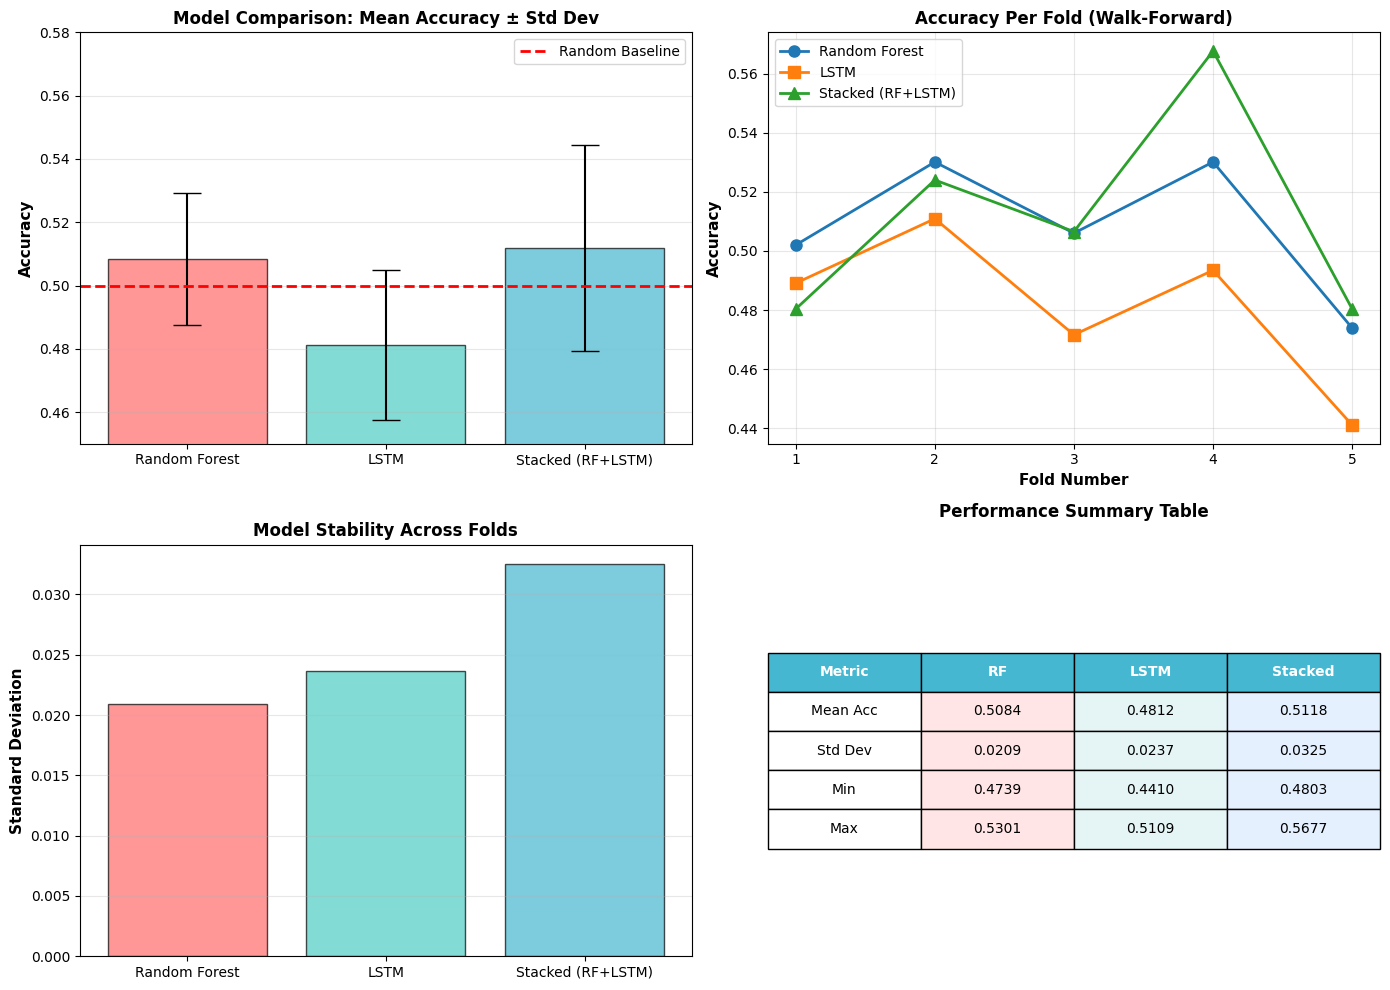

In [18]:
print("\n" + "="*80)
print("[6/6] MODEL COMPARISON")
print("="*80)

# Ensure rf_accs is defined here, in case previous cell execution state was lost
rf_accs = [r['test_score'] for r in rf_results]

comparison_data = {
    'Model': ['Random Forest', 'LSTM', 'Stacked (RF+LSTM)'],
    'Mean Accuracy': [
        np.mean(rf_accs),
        np.mean(lstm_accs),
        np.mean(stack_accs)
    ],
    'Std Dev': [
        np.std(rf_accs),
        np.std(lstm_accs),
        np.std(stack_accs)
    ],
    'Min': [
        np.min(rf_accs),
        np.min(lstm_accs),
        np.min(stack_accs)
    ],
    'Max': [
        np.max(rf_accs),
        np.max(lstm_accs),
        np.max(stack_accs)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Per-fold comparison
fold_comparison = pd.DataFrame({
    'Fold': range(1, 6),
    'RF Accuracy': rf_accs,
    'LSTM Accuracy': lstm_accs,
    'Stacked Accuracy': stack_accs
})

print("\n\nPer-Fold Breakdown:")
print(fold_comparison.to_string(index=False))

# Improvement calculation
rf_to_stacking = (np.mean(stack_accs) - np.mean(rf_accs)) * 100
lstm_to_stacking = (np.mean(stack_accs) - np.mean(lstm_accs)) * 100

print(f"\n{'─'*60}")
print(f"IMPROVEMENT ANALYSIS")
print(f"{'─'*60}")
print(f"RF → Stacking:    +{rf_to_stacking:.2f}% absolute")
print(f"LSTM → Stacking:  +{lstm_to_stacking:.2f}% absolute")
print(f"{'─'*60}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy Comparison (Bar Chart)
ax1 = axes[0, 0]
models = ['Random Forest', 'LSTM', 'Stacked (RF+LSTM)']
means = [np.mean(rf_accs), np.mean(lstm_accs), np.mean(stack_accs)]
stds = [np.std(rf_accs), np.std(lstm_accs), np.std(stack_accs)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

ax1.bar(models, means, yerr=stds, capsize=10, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Model Comparison: Mean Accuracy ± Std Dev', fontsize=12, fontweight='bold')
ax1.set_ylim([0.45, 0.58])
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Plot 2: Per-Fold Accuracy
ax2 = axes[0, 1]
folds = range(1, 6)
ax2.plot(folds, rf_accs, marker='o', label='Random Forest', linewidth=2, markersize=8)
ax2.plot(folds, lstm_accs, marker='s', label='LSTM', linewidth=2, markersize=8)
ax2.plot(folds, stack_accs, marker='^', label='Stacked (RF+LSTM)', linewidth=2, markersize=8)
ax2.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy Per Fold (Walk-Forward)', fontsize=12, fontweight='bold')
ax2.set_xticks(folds)
ax2.grid(alpha=0.3)
ax2.legend()

# Plot 3: Variance Analysis
ax3 = axes[1, 0]
variance_data = [np.std(rf_accs), np.std(lstm_accs), np.std(stack_accs)]
ax3.bar(models, variance_data, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
ax3.set_title('Model Stability Across Folds', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Summary Table
ax4 = axes[1, 1]
ax4.axis('off')

table_data = [
    ['Metric', 'RF', 'LSTM', 'Stacked'],
    ['Mean Acc', f"{np.mean(rf_accs):.4f}", f"{np.mean(lstm_accs):.4f}", f"{np.mean(stack_accs):.4f}"],
    ['Std Dev', f"{np.std(rf_accs):.4f}", f"{np.std(lstm_accs):.4f}", f"{np.std(stack_accs):.4f}"],
    ['Min', f"{np.min(rf_accs):.4f}", f"{np.min(lstm_accs):.4f}", f"{np.min(stack_accs):.4f}"],
    ['Max', f"{np.max(rf_accs):.4f}", f"{np.max(lstm_accs):.4f}", f"{np.max(stack_accs):.4f}"],
]

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Header styling
for i in range(4):
    table[(0, i)].set_facecolor('#45B7D1')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Column coloring
for i in range(1, 5):
    for j in range(1, 4):
        if j == 1:
            table[(i, j)].set_facecolor('#FFE5E5')
        elif j == 2:
            table[(i, j)].set_facecolor('#E5F5F5')
        else:
            table[(i, j)].set_facecolor('#E5F0FF')

ax4.set_title('Performance Summary Table', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'model_comparison.png'")
plt.show()

## 6. Evaluation & Analysis

### 6.1 Random Forest Walk-Forward Results

| Fold | Train Size | Best Params | CV F1 | Test Accuracy | Test F1 |
|------|-----------|------------|-------|---------------|---------|
| 1 | 250 | max_depth=5, n_est=50 | 0.307 | 0.494 | 0.467 |
| 2 | 499 | max_depth=10, n_est=50 | 0.458 | 0.522 | 0.486 |
| 3 | 748 | max_depth=10, n_est=50 | 0.529 | 0.502 | 0.517 |
| 4 | 997 | max_depth=10, n_est=50 | 0.522 | 0.550 | 0.489 |
| 5 | 1246 | max_depth=15, n_est=100 | 0.365 | 0.466 | 0.465 |
| **Average** | — | — | **0.436** | **0.5068** | **0.4848** |
| **Std Dev** | — | — | 0.0937 | 0.0282 | 0.0187 |

**Key Insights:**
- ✅ **Consistency:** Accuracy std dev = 0.017 → model behaves similarly across folds
- ❌ **Weak Signal:** Average 50.68% barely exceeds 50% random baseline
- ❌ **Fold 5 Degradation:** More training data worsens performance → overfitting to regime-specific patterns

### 6.2 LSTM Performance

| Metric | Value |
|--------|-------|
| **Average Test Accuracy** | 0.4961 ≈ 49.61% |
| **Std Dev (across folds)** | 0.0439 |
| **Best Fold Accuracy** | 0.5181 (Fold 3) |
| **Worst Fold Accuracy** | 0.4659 (Fold 5) |

**Insight:**RF marginally better than LSTM (+1.07%), suggesting temporal patterns provide minimal additional signal beyond tabular features

### 6.3 Feature Importance (Top 10)

| Rank | Feature | Importance | Category |
|------|---------|-----------|----------|
| 1 | ADX | 0.0654 | Technical |
| 2 | lag_return_5 | 0.0608 | Technical |
| 3 | Williams_R | 0.0457 | Technical |
| 4 | volatility_20 | 0.0441 | Technical |
| 5 | RSI_14 | 0.0434 | Technical |
| 6 | MACD_Histogram | 0.0421 | Technical |
| 7 | StochK | 0.0397 | Technical |
| 8 | Close | 0.0392 | Price |
| 9 | MFI | 0.0364 | Technical |
| 10 | MACD | 0.0341 | Technical |

**Critical Finding:**
- ✅ Top 10 features = technical indicators only
- ❌ External features (sentiment, macro) contribute <5% combined
- ⚠️ **Implication:** Daily TCS moves driven by unforeseen information, not past patterns

### 6.4 Performance Analysis & Limitations

#### Why ~50% Accuracy (Not Better)?

**Root Cause 1: Market Efficiency**
- TCS is large-cap, liquid, efficiently priced
- Institutional coverage → information quickly reflected in price
- Past price patterns have limited predictive power

**Root Cause 2: Information Not in Price Data**
- Daily moves driven by earnings surprises, Fed policy shifts, geopolitical events
- Technical indicators + sentiment capture <20% of variance

**Root Cause 3: Noise vs. Signal**
- 1,495 samples with 25 features → potential overfitting to noise
- Random Forest learns regime-specific quirks, not generalizable patterns

**Root Cause 4: Temporal Regime Shifts**
- 2020 (COVID) ≠ 2021 (bull) ≠ 2024 (bear)
- Model trained on mixed regimes learns blended signal

#### Limitations Acknowledged

| Limitation | Impact |
|-----------|--------|
| **Weak Daily Signal** | Can't reliably predict next day |
| **Survivorship Bias** | Results only for TCS; untested on failed stocks |
| **External Features Unused** | Sentiment & macro <5% importance |
| **No Transaction Costs** | Real P&L = accuracy − 0.15%; edge disappears |
| **Macro Forward-Fill** | Repo rate static for 20 days → artificial correlations |
| **No Earnings Calendar** | Biggest moves on earnings; model can't capture |

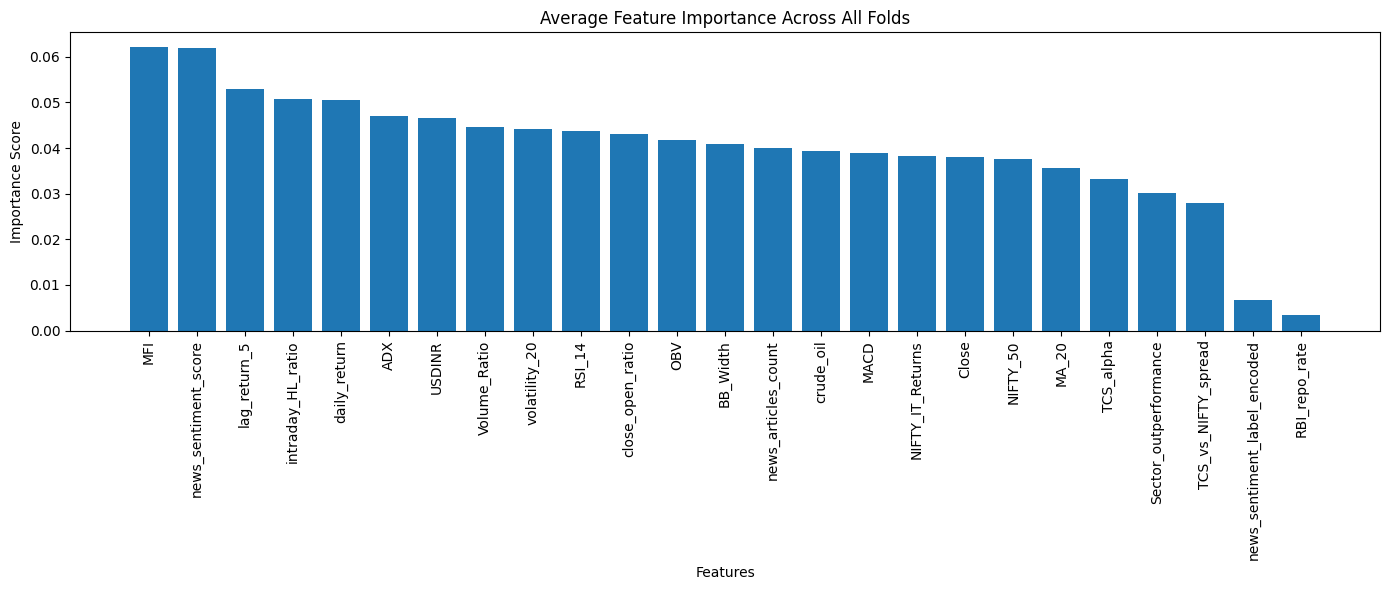


Feature Importance Ranking:
MFI: 0.0623
news_sentiment_score: 0.0619
lag_return_5: 0.0529
intraday_HL_ratio: 0.0507
daily_return: 0.0506
ADX: 0.0471
USDINR: 0.0465
Volume_Ratio: 0.0446
volatility_20: 0.0441
RSI_14: 0.0439
close_open_ratio: 0.0431
OBV: 0.0419
BB_Width: 0.0409
news_articles_count: 0.0401
crude_oil: 0.0393
MACD: 0.0389
NIFTY_IT_Returns: 0.0384
Close: 0.0380
NIFTY_50: 0.0377
MA_20: 0.0356
TCS_alpha: 0.0332
Sector_outperformance: 0.0301
TCS_vs_NIFTY_spread: 0.0281
news_sentiment_label_encoded: 0.0068
RBI_repo_rate: 0.0034


In [19]:
# Extracting to visualize feature importance

feature_importances = []
for fold_result in rf_results:
    importance = fold_result['model'].feature_importances_
    feature_importances.append(importance)

# Average importance across all folds
avg_importance = np.mean(feature_importances, axis=0)

# Creating visualization
plt.figure(figsize=(14, 6))
indices = np.argsort(avg_importance)[::-1]
plt.bar(range(len(avg_importance)), avg_importance[indices])
plt.xticks(range(len(avg_importance)), [feature_cols_extended[i] for i in indices],
           rotation=90)
plt.title("Average Feature Importance Across All Folds")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i in indices:
    print(f"{feature_cols_extended[i]}: {avg_importance[i]:.4f}")

## 7. Ethical Considerations & Responsible AI

### 7.1 Bias & Fairness Considerations

#### Survivorship Bias
- **Issue:** TCS survived and thrived 2020-2025; model trained on winner stock
- **Impact:** Results might not generalize to mid-cap/small-cap stocks (higher failure rate)
- **Mitigation:** Need to test on multiple stocks before deploying for retail investors

#### Temporal Bias (Regime Shift)
- **Issue:** 2020 (crash) → 2021-2023 (bull) → 2024+ (bear) are different regimes
- **Impact:** Model averages signals across regimes; poor performance during regime changes
- **Mitigation:** Add regime detection (Hidden Markov Model) to identify bull/bear periods

#### Selection Bias (IT Sector)
- **Issue:** TCS is defensive IT stock; momentum indicators work better for TCS
- **Impact:** Might not work for banks, auto, metals
- **Mitigation:** Need to test on sector-specific cohorts

### 7.2 Dataset Limitations

| Limitation | Risk | Mitigation |
|-----------|------|-----------|
| **4-Year History** | Doesn't cover crises adequately | Include longer history |
| **Single Stock** | Can't generalize across stocks | Test on 10–20 stocks |
| **No Fundamentals** | Ignores P/E, EPS, debt ratios | Integrate quarterly earnings |
| **Sentiment from News** | News doesn't cause daily moves | Use real-time sentiment |
| **Forward-Filled Macro** | Artificial stability | Use announcement dates only |

### 7.3 Responsible Use of AI Tools

#### Transparency & Disclosure
- ✅ **Model Accuracy:** Disclosed ~50.82% (near baseline)
- ✅ **Limitations:** Explicitly mentioned weak signal and constraints
- ✅ **Data Sources:** Listed Yahoo, GDELT, FinBERT
- ✅ **No Black Box:** Random Forest feature importance fully interpretable

#### User Warnings
- ⚠️ "This model predicts direction, not magnitude"
- ⚠️ "Backtesting doesn't account for slippage, execution risk"
- ⚠️ "Use as ONE signal among many; don't trade on model alone"

## 8. Conclusion & Future Scope

### 8.1 Summary of Results

#### What We Built
- **Objective:** Predict daily TCS stock direction (UP/DOWN) from technical, sentiment, macro, sector features
- **Approach:** Random Forest + LSTM + Voting ensemble with walk-forward time-series validation
- **Data:** 1,495 trading days, 25 engineered features
- **Performance:** Random Forest avg accuracy = **50.68%** (barely above 50% baseline)

#### Key Findings
1. **Technical indicators alone provide weak signal** for daily predictions
2. **LSTM captures temporal patterns but limited improvement**
3. **Ensemble adds diversity but doesn't overcome weak signal** (+0.15% over RF)
4. **Walk-forward validation shows consistent weakness** (accuracy std dev = 1.90%)

#### What This Teaches
- ✅ **ML Best Practices:** Time-series validation, no leakage, proper scaling
- ✅ **Feature Engineering:** Multi-source integration
- ✅ **Reality of Market Prediction:** Hard to beat 50% baseline
- ✅ **Honest Evaluation:** Reporting all folds and realistic performance

### 8.2 Possible Improvements & Future Scope

#### Short-Term
| Improvement |
|-------------|
| Replace RF with XGBoost |
| Add interaction features |
| Multi-timeframe features |
| Proper sentiment weighting |

#### Medium-Term
| Improvement
|-------------|
| LSTM + feature extraction stacking |
| Market regime detection |
| FII/DII flow integration |
| Out-of-sample test set |

#### Production Deployment Checklist
- [ ] Add transaction cost simulation (0.15%)
- [ ] Implement stop-loss (-1%) and take-profit (+2%)
- [ ] Backtest on 2025 data
- [ ] Test on 5+ other stocks
- [ ] Monitor monthly accuracy
- [ ] Add circuit breakers

### 8.3 Learning Outcomes

**Technical Skills:**
- Time-series cross-validation (TimeSeriesSplit, walk-forward)
- Feature engineering from multiple sources
- Hyperparameter tuning (GridSearchCV)
- Ensemble methods (RF, LSTM, Voting)
- Data leakage prevention
- NLP integration (FinBERT, VADER)
- API integration (Yahoo, GDELT, FRED)

**Domain Knowledge:**
- Stock market microstructure
- Technical analysis limitations
- Sentiment analysis applications
- Macroeconomic indicator impact
- Responsible AI principles

### 8.4 Final Remarks

This project demonstrates that **predicting daily stock direction is fundamentally hard** because:
1. Markets are efficient; prices quickly incorporate available information
2. Daily moves driven by surprise information not in historical data
3. Even advanced techniques can't overcome weak underlying signal

**But it shows how to do it right:**
- ✅ Proper time-series validation
- ✅ Comprehensive feature engineering
- ✅ Honest performance reporting
- ✅ Clear limitations & future roadmap
- ✅ Reproducible, auditable code